In [2]:
##Standards Librairies import
import os
from time import time
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objs as go

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import homogeneity_score, adjusted_rand_score, adjusted_mutual_info_score

# Clustering Librairies import
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from yellowbrick import *

In [4]:
!pip list

Package                            Version
---------------------------------- --------------------
absl-py                            1.1.0
alabaster                          0.7.12
anaconda-client                    1.9.0
anaconda-navigator                 2.2.0
anaconda-project                   0.10.1
anyio                              2.2.0
appdirs                            1.4.4
argh                               0.26.2
argon2-cffi                        20.1.0
arrow                              0.13.1
asn1crypto                         1.4.0
astroid                            2.6.6
astropy                            4.3.1
astunparse                         1.6.3
async-generator                    1.10
atomicwrites                       1.4.0
attrs                              21.2.0
autopep8                           1.5.7
Babel                              2.9.1
backcall                           0.2.0
backports.functools-lru-cache      1.6.4
backports.shutil-get-terminal-size 

## Stabilité à l'initialisation du K-Means

In [6]:
rfm_df1 = pd.read_csv("olist_customers_segmentation1.csv")
rfm_df1.head()

,customer_unique_id,Recency,Frequency,Monetary,TimeToDeliveryinDays,DeliveryDelayinDays,review_score,kmeans_label
0,0000366f3b9a7992bf8c76cfdf3221e2,111.0,1,141.90,6.41,-4.13,5.0,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114.0,1,27.19,3.29,-4.25,4.0,1
2,0000f46a3911fa3c0805444483337064,537.0,1,86.22,25.73,-1.39,3.0,0
3,0000f6ccb0745a6a4b88665a16c9f078,321.0,1,43.62,20.04,-11.11,4.0,1
4,0004aac84e0df4da2b147fca70cf8255,288.0,1,196.89,13.14,-7.04,5.0,0


In [9]:
kmeans_labels = rfm_df1["kmeans_label"]
labels = kmeans_labels

In [10]:
rfm_df1.drop(['customer_unique_id'], axis=1, inplace=True)

In [11]:
rfm_df1.head()

,Recency,Frequency,Monetary,TimeToDeliveryinDays,DeliveryDelayinDays,review_score,kmeans_label
0,111.0,1,141.90,6.41,-4.13,5.0,2
1,114.0,1,27.19,3.29,-4.25,4.0,1
2,537.0,1,86.22,25.73,-1.39,3.0,0
3,321.0,1,43.62,20.04,-11.11,4.0,1
4,288.0,1,196.89,13.14,-7.04,5.0,0


In [12]:
def bench_k_means(model, name, data, labels):
    t0 = time()
    estimator = make_pipeline(MinMaxScaler(), model).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[1].inertia_]
    
    # Test differents metrics on pred labels
    clustering_metrics = [
        homogeneity_score,
        adjusted_rand_score,
        adjusted_mutual_info_score]
    results += [m(labels, estimator[1].labels_) for m in clustering_metrics]
    
    # Show the results
    formatter_result = ("{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}"
                        "\t{:.3f}\t{:.3f}")
    print(formatter_result.format(*results))

In [14]:
print("Scores de stabilité à l'initialisation")
print(53 * '_')
print('Iteration\tFitTime\tInertia\tHomo\tARI\tAMI')
print(53 * '_')

for i in range(10):
    imodel = KMeans(n_clusters=4, n_init=1, init="k-means++")
    bench_k_means(model = imodel, name="Iter "+str(i), 
                  data=rfm_df1, labels=kmeans_labels)

print(53 * '_')

Scores de stabilité à l'initialisation
_____________________________________________________
Iteration	FitTime	Inertia	Homo	ARI	AMI
_____________________________________________________
Iter 0   	0.181s	2869	1.000	1.000	1.000
Iter 1   	0.047s	2869	1.000	1.000	1.000
Iter 2   	0.052s	2869	1.000	1.000	1.000
Iter 3   	0.052s	2869	1.000	1.000	1.000
Iter 4   	0.051s	2869	1.000	1.000	1.000
Iter 5   	0.051s	2869	1.000	1.000	1.000
Iter 6   	0.052s	2869	1.000	1.000	1.000
Iter 7   	0.058s	2869	1.000	1.000	1.000
Iter 8   	0.047s	2869	1.000	1.000	1.000
Iter 9   	0.051s	2869	1.000	1.000	1.000
_____________________________________________________


**Stabilité temporelle de la segmentation**

Dans le but d'établir un contrat de maintenance de l'algorithme de segmentation client, nous devons tester sa stabilité dans le temps et voir, par exemple, à quel moment les clients changent de Cluster.

Pour cela, nous devons recalculer toutes les features en fonction d'une période donnée.

In [34]:
from time import time

def make_dataset(dpath="datas/", initial=False, period=2):
    """Cleaning and feature engineering on complete Olist data 
        for preparation of unsupervised classification (K-Means).

    Parameters
    ----------
    initial : boolean
        Defines whether the created dataset is the initial dataset.
    period : int
        Increment period in months after initial dataset.
    """
    start_time = time()
    print("Création du dataset en cours ...")
    
    # Load datasets
    customers = pd.read_csv("olist_customers_dataset.csv")
    geolocation = pd.read_csv("olist_geolocation_dataset.csv")
    orders = pd.read_csv("olist_orders_dataset.csv")
    order_items = pd.read_csv("olist_order_items_dataset.csv")
    order_payments = pd.read_csv("olist_order_payments_dataset.csv")
    order_reviews = pd.read_csv("olist_order_reviews_dataset.csv")
    products = pd.read_csv("olist_products_dataset.csv")
    categories_en = pd.read_csv("product_category_name_translation.csv")
    
    # Merge datasets
    # Orders
    orders.drop(["order_approved_at",
                 "order_delivered_carrier_date", 
                 "order_estimated_delivery_date"],
                axis=1, inplace=True)

    order_items.drop(["seller_id",
                      "shipping_limit_date"],
                     axis=1, inplace=True)
    order_items = pd.merge(order_items, orders,
                           how="left",
                           on="order_id")
    
    datetime_cols = ["order_purchase_timestamp", 
                     "order_delivered_customer_date"]
    for col in datetime_cols:
        order_items[col] = order_items[col].astype('datetime64[ns]')
        
    # Select orders on period
    start=order_items["order_purchase_timestamp"].min()
    if(initial == True):
        period = 12
    else:
        period = 12+period
    stop=start + pd.DateOffset(months=period)
        
    order_items = order_items[(order_items["order_purchase_timestamp"]>=start)
                              & (order_items["order_purchase_timestamp"]<stop)]
    
    # List of orders on period
    period_orders = order_items.order_id.unique()
    
    # Calculate other features on period
    order_payments = order_payments[order_payments["order_id"].isin(period_orders)]
    order_items = pd.merge(order_items, order_payments,
                           how="left",
                           on="order_id")
                
    order_reviews = order_reviews[order_reviews["order_id"].isin(period_orders)]
    order_items = pd.merge(order_items,
                           order_reviews.groupby("order_id").agg({
                               "review_score": "mean"}),
                           how="left",
                           on="order_id")
    
    # Delivery time
    order_items["delivery_delta_days"] = (order_items.order_delivered_customer_date
                                          - order_items.order_purchase_timestamp)\
                                         .dt.round('1d').dt.days
    order_items.drop("order_delivered_customer_date", axis=1, inplace=True)
    
    # Products
    products = pd.merge(products, categories_en,
                    how="left",
                    on="product_category_name")

    del_features_list = ["product_category_name", "product_weight_g",
                         "product_length_cm", "product_height_cm",
                         "product_width_cm", "product_name_lenght", 
                         "product_description_lenght", "product_photos_qty"]
    products.drop(del_features_list, axis=1, inplace=True)
    products = products.rename(columns={"product_category_name_english":
                                        "product_category_name"})
        
    
    products.drop("product_category_name", axis=1, inplace=True)

    order_items = pd.merge(order_items, products, 
                           how="left",
                           on="product_id")
    
    
    # Customers
    order_items = pd.merge(order_items, customers[["customer_id",
                                                   "customer_unique_id",
                                                   "customer_state"]],
                           on="customer_id",
                           how="left")
    
    # Group datas by unique customers
    data = order_items.groupby(["customer_unique_id"]).agg(
        nb_orders=pd.NamedAgg(column="order_id", aggfunc="nunique"),
        Monetary=pd.NamedAgg(column="payment_value", aggfunc="sum"),
        mean_review_score=pd.NamedAgg(column="review_score", aggfunc="mean"),
        mean_delivery_days=pd.NamedAgg(column="delivery_delta_days", aggfunc="mean"),
        first_order=pd.NamedAgg(column="order_purchase_timestamp", aggfunc="min"),
        last_order=pd.NamedAgg(column="order_purchase_timestamp", aggfunc="max"))
    
    # Final feature engineering
    # Mean delay between 2 orders
    data["order_mean_delay"] = [(y[1] - y[0]).round('1d').days if y[1] != y[0]
                                else (stop - y[0]).round('1d').days
                                for x,y in data[["first_order","last_order"]].iterrows()]
    data["order_mean_delay"] = data["order_mean_delay"] / data["nb_orders"]
    data.drop(["first_order", "last_order"], axis=1, inplace=True)
    
    # complete missing values
    features_to_fill = data.isnull().sum()
    features_to_fill = list(features_to_fill[features_to_fill.values > 0].index)
    
    print(54*"_")
    print("Features complétées avec la valeur la plus fréquente :")
    print(54*"_")
    for f in features_to_fill:
        data[f] = data[f].fillna(data[f].mode()[0])
        print(f,"\t", data[f].mode()[0])
    print(54*"_")
    
    end_time = time()
    print("Durée d'execution du Feature engineering : {:.2f}s".format(end_time - start_time))
    
    return data

In [35]:
# Initial period of 12 months
data_init = make_dataset(initial=True, period=2)

Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_review_score 	 5.0
mean_delivery_days 	 8.0
______________________________________________________
Durée d'execution du Feature engineering : 6.03s


In [36]:
data_init.head(3)

,nb_orders,Monetary,mean_review_score,mean_delivery_days,order_mean_delay
customer_unique_id,,,,,
0000f46a3911fa3c0805444483337064,1,86.22,3.0,26.0,178.0
0005e1862207bf6ccc02e4228effd9a0,1,150.12,4.0,4.0,184.0
0006fdc98a402fceb4eb0ee528f6a8d4,1,29.00,3.0,16.0,48.0


In [19]:
orders = pd.read_csv("olist_orders_dataset.csv")
orders = orders.loc[orders.order_status == "delivered", 
                    "order_purchase_timestamp"]
orders = pd.to_datetime(orders)
time_delta = int((orders.max() - orders.min())/np.timedelta64(1,'M'))
print("La période complète des commandes porte sur {} mois.".format(time_delta))

La période complète des commandes porte sur 23 mois.


Pour déterminer le moment où les clients changent de cluster, nous allons itérer le K-Means sur toute la période avec des deltas de 1 mois et calculer le score ARI, en prenant garde à bien comparer les mêmes clients (ceux des 12 mois initiaux).

In [26]:
# Kmeans on initial period
kmeans_init = Pipeline([("preprocessor", MinMaxScaler()),
                        ("kmeans", KMeans(4, random_state=42))])
kmeans_init.fit(data_init)
init_labels = kmeans_init.named_steps['kmeans'].labels_

In [28]:
ari_score = []
for p in np.arange(1,(time_delta-12),1):
    # Create dataset for period
    data_period = make_dataset(initial=False, 
                                   period=p)
        
    # Filter on initial customer client
    data_period = data_period[data_period.index.isin(data_init.index)]
    
    # K-Means
    kmeans_p = Pipeline([("preprocessor", MinMaxScaler()),
                         ("kmeans", KMeans(4, random_state=42))])
    kmeans_p.fit(data_period)
    p_labels = kmeans_p.named_steps['kmeans'].labels_
    
    # Calculate ARI score
    ari_p = adjusted_rand_score(init_labels, kmeans_p[1].labels_)
    ari_score.append([p,ari_p])

Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_review_score 	 5.0
mean_delivery_days 	 8.0
______________________________________________________
Durée d'execution du Feature engineering : 6.76s
Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_review_score 	 5.0
mean_delivery_days 	 8.0
______________________________________________________
Durée d'execution du Feature engineering : 7.37s
Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_review_score 	 5.0
mean_delivery_days 	 8.0
___________________________________________________

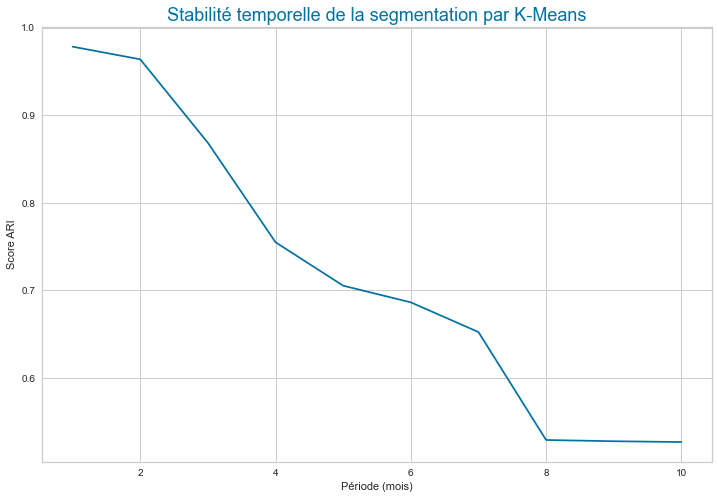

In [29]:
ari_score = pd.DataFrame(ari_score, columns=["periode", "ARI"])

# plot ARI Score
fig = plt.figure(figsize=(12,8))
sns.lineplot(data=ari_score, x="periode", y="ARI")

plt.xlabel("Période (mois)")
plt.ylabel("Score ARI")
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=18,
          color="b")
plt.show()

Sur ce plot des scores ARI obtenus sur les itérations par période de 1 mois, on remarque une forte inflexion après 2-4 mois sur les clients initiaux.

Il faudra donc prévoir la maintenance du programme de segmentation a minima tous les trimestres dans un premier temps puis re-tester cette stabilité temporelle au fil du temps afin de l'affiner. Il sera donc nécessaire de redéfinir les segments clients à chaque maintenance.